# Sybil exploration grant climate

In [1]:
import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

In [2]:
from sblegos.TransactionAnalyser import TransactionAnalyser
from sbutils.LoadData import LoadData
from sbdata.FlipsideApi import FlipsideApi

In [3]:
current_dir = Path(os.getcwd())

### Initialisation of the data

#### Grant data initialisation

In [84]:
path_to_grants = "data/grants"
path_to_contributor_address = os.path.join(path_to_grants, "address")

In [5]:
full_path_add = os.path.join(current_dir, path_to_contributor_address)
files = os.listdir(full_path_add)
files

['df_contribution_address_CLIMATE.csv',
 'df_contribution_address_ETHEREUM.csv',
 'df_contribution_address_FANTOM.csv',
 'df_contribution_address_GR15.csv',
 'df_contribution_address_OSS.csv',
 'df_contribution_address_UNICEF.csv',
 'unique_ctbt_address.csv']

In [87]:
csv = files[0]
gr_round = "CLIMATE"
df_address = pd.read_csv(os.path.join(full_path_add, csv))
list_address = df_address["address"].tolist()

The list_address is then used to load all the transactions from the grant data.

#### Data loader initialisation

In [7]:
path_to_parent = Path(current_dir).parent
path_to_tx = os.path.join(path_to_parent, 'transactions_full')
print(path_to_tx)

c:\Users\DELL Admin\Documents\ODC\DataBuilderHackathon\transactions_full


Initialize the data loader with the path to the transactions 

In [8]:
data_loader = LoadData(path_to_tx)

The data loader is then used to load the data from the grant data. It takes some time to load the data. 3 minutes on my computer. 

In [9]:
df_tx = data_loader.create_df_tx('ethereum', list_address)

#### Sybil scorer TransactionAnalyser initialisation and exploration

In [10]:
tx_analyser = TransactionAnalyser(df_tx, df_address=df_address)

Verify matching addresses because the transaction data is not always complete for a specific chain. ie an address may have contributed from a chain but have zero transactions on the studyed chain, here ethereum.

In [11]:
df_matching_address = pd.DataFrame(df_tx.EOA.unique(), columns=["address"])
df_matching_address.head(2)

,address
0,0x001f41de6f455d6df74a669c6b21b6dda1bae644
1,0x002153708f11f2651215059eea30820ee4d49ff3


In [ ]:
df_matching_address.shape

In [12]:
df_matching_address['seed_same_naive'] = df_matching_address.loc[:, 'address'].apply(lambda x : tx_analyser.has_same_seed_naive(x))

In [13]:
df_matching_address['seed_same'] = df_matching_address.loc[:, 'address'].apply(lambda x : tx_analyser.has_same_seed(x))

In [14]:
df_matching_address['seed_suspicious'] = df_matching_address.loc[:, 'seed_same_naive'].ne(df_matching_address.loc[:, 'seed_same'])

In [15]:
df_matching_address['less_5_tx'] = df_matching_address.loc[:, 'address'].apply(lambda x : tx_analyser.has_less_than_n_transactions(x, 5))
df_matching_address['less_10_tx'] = df_matching_address.loc[:, 'address'].apply(lambda x : tx_analyser.has_less_than_n_transactions(x, 10))

In [16]:
df_matching_address['interacted_other_ctbt'] = df_matching_address.loc[:, 'address'].apply(lambda x : tx_analyser.has_interacted_with_other_contributor(x))

In [17]:
df_matching_address.set_index('address', inplace=True)

In [18]:
df_matching_address.sum()

seed_same_naive          1854
seed_same                1887
seed_suspicious            35
less_5_tx                 843
less_10_tx               1035
interacted_other_ctbt     251
dtype: int64

Many addresses have the same seed wallet. This number should be lowered using tags to remove same wallet addresses comming from centralised exchange.

In [19]:
list_same_seed_wallets = df_matching_address[np.logical_or(df_matching_address['seed_same_naive'], df_matching_address['seed_same'])].index.tolist()

In [51]:
df_seeder = tx_analyser.df_seed_wallet

In [29]:
seeder = np.unique(df_seeder.from_address.values)
print(len(seeder))

655


In [45]:
FLIPSIDE_API_KEY = os.environ.get('FLIPSIDE_API_KEY')
flipside_api  = FlipsideApi(FLIPSIDE_API_KEY)
sql = flipside_api.get_cross_chain_info_sql_query(
            seeder,
            info_type="label")
df_labels = flipside_api.execute_query(sql)

In [46]:
df_labels.head(2)

,system_created_at,insert_date,blockchain,address,creator,label_type,label_subtype,address_name,project_name
0,2022-01-03 20:43:08.094,2022-01-03 20:43:06.000,ethereum,0x9696f59e4d72e237be84ffd425dcad154bf96976,flipside,cex,hot_wallet,binance 18,binance
1,2021-11-30 00:15:28.111,2021-11-29 23:00:05.000,ethereum,0x96fc4553a00c117c5b0bed950dd625d1c16dc894,flipside,cex,hot_wallet,changelly,changelly


In [47]:
df_labels.shape[0]

93

In [48]:
df_labels.label_type.unique()

array(['cex', 'dapp', 'operator', 'token'], dtype=object)

In [49]:
sql = flipside_api.get_cross_chain_info_sql_query(
            seeder,
            info_type="tag")
df_tags = flipside_api.execute_query(sql)

In [50]:
df_tags

""


No tag where found in the seeders

Lets remove these wallets from the case where has_same_seed is raised.

In [59]:
df_matching_address['seed_without_label'] = df_seeder.apply(lambda x : x['from_address'] not in df_labels.address.values, axis=1)

In [61]:
df_matching_address.fillna(True, inplace=True)

In [62]:
df_matching_address["same_seed_without_label"] = np.logical_and(np.logical_or(df_matching_address['seed_same_naive'], df_matching_address['seed_same']), df_matching_address["seed_without_label"])

In [64]:
df_matching_address.sum()

seed_same_naive            1854
seed_same                  1887
seed_suspicious              35
less_5_tx                   843
less_10_tx                 1035
interacted_other_ctbt       251
seed_without_label          707
same_seed_without_label     176
dtype: int64

In [65]:
df_matching_reduced = df_matching_address.loc[:, ['seed_suspicious', 'less_5_tx', 'interacted_other_ctbt', 'same_seed_without_label']]

In [80]:
suspicious_wallet_count = (df_matching_reduced.T.sum(axis=0) > 0).sum()
total_wallet_count = df_matching_reduced.shape[0]
print(f"There are {suspicious_wallet_count} suspicious wallets out of {total_wallet_count} wallets wich is a ratio of {round(suspicious_wallet_count/total_wallet_count*100)}%.")

There are 1199 suspicious wallets out of 2463 wallets wich is a ratio of 49%.


#### Now lets look at the project that have many suspicious contributors.

We first load all the votes and then filter for the climate round

In [85]:
df_contributions = pd.read_csv(os.path.join(path_to_grants, "df_contribution_normalized.csv"))
df_applications = pd.read_csv(os.path.join(path_to_grants, "df_application_normalized.csv"))

C:\Users\DELL Admin\AppData\Local\Temp\ipykernel_8116\2868675674.py:1: DtypeWarning: Columns (0,4,7,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_contributions = pd.read_csv(os.path.join(path_to_grants, "df_contribution_normalized.csv"))


In [92]:
df_ctbt_round = df_contributions.loc[df_contributions['project_round'] == gr_round,: ]

In [93]:
df_ctbt_round.shape

(8556, 12)

In [90]:
df_ctbt_round.columns

Index(['ctbt_id', 'ctbt_token', 'ctbt_amount', 'ctbt_address',
       'project_address', 'ctbt_timestamp', 'project_round', 'checkout_type',
       'ctbt_amount_in_usd', 'raw_amount_in_token', 'ctbt_tx_hash',
       'ctbt_modified_on'],
      dtype='object')

In [91]:
df_ctbt_round.ctbt_address.nunique()

2464

In [174]:
df_ctbt_round.project_round.unique()

array(['CLIMATE'], dtype=object)

Many contributors have contributed several times to the climate grants. This is a sign that they are many sybils.

In [98]:
(df_ctbt_round.groupby('ctbt_address').ctbt_id.count() > 1).sum()

812

In [100]:
df_ctbt_round.groupby(['project_address', 'ctbt_address']).ctbt_id.count().sort_values(ascending=False)

project_address                             ctbt_address                              
0x14cb60f6aca2b2a68d975743bacb33f01f587da5  0x67f06a56dbab410d1e06dc75493a1a09fc788047    3
0x48f2696fb6fab7ac0956175b2e25b456e61b3fcf  0x67f06a56dbab410d1e06dc75493a1a09fc788047    3
0x0f7272f8873b68b2a2f52685311822d831afc8b4  0x67f06a56dbab410d1e06dc75493a1a09fc788047    3
0x41dde2dc7f718d5f764fc97e8d122864587642d4  0x67f06a56dbab410d1e06dc75493a1a09fc788047    3
0x8d860d4f254ed45946f5fb0e3243c1db63a4ea2f  0x719028736f10164c838ef129936779ed739312f2    2
                                                                                         ..
0x41dde2dc7f718d5f764fc97e8d122864587642d4  0x140063a309fa9cab5f50c55ffd4fae592177a263    1
                                            0x12b71792cb33186111f1a973e31c22c92547beae    1
                                            0x12358f3801e916d7df8d86d7be9e48559837f6a7    1
                                            0x10c0613d50cf8cd8886a9f248ce13d41b1d90fa

In [105]:
gb_has_multi_ctbt_to_project = df_ctbt_round.groupby(['project_address', 'ctbt_address']).ctbt_id.count() > 1

In [109]:
has_multi_ctbt_to_project = gb_has_multi_ctbt_to_project.reset_index().groupby('ctbt_address').sum().sort_values(by='ctbt_id', ascending=False) > 0

C:\Users\DELL Admin\AppData\Local\Temp\ipykernel_8116\1799691189.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  has_multi_ctbt_to_project = gb_has_multi_ctbt_to_project.reset_index().groupby('ctbt_address').sum().sort_values(by='ctbt_id', ascending=False) > 0


In [113]:
print(f"{has_multi_ctbt_to_project.sum().ctbt_id} out of {has_multi_ctbt_to_project.shape[0]} wallets have contributed more than one time to a project.")

69 out of 2464 wallets have contributed more than one time to a project.


In [114]:
df_matching_reduced["many_ctbt_to_project"] = has_multi_ctbt_to_project

In [116]:
df_matching_reduced.head(2)

,seed_suspicious,less_5_tx,interacted_other_ctbt,same_seed_without_label,many_ctbt_to_project
address,,,,,
0x001f41de6f455d6df74a669c6b21b6dda1bae644,False,True,False,False,False
0x002153708f11f2651215059eea30820ee4d49ff3,False,False,False,False,False


In [124]:
suspicious_address = df_matching_reduced[df_matching_reduced.sum(axis=1)>0].index.values

Which projects are the most impacted?

In [128]:
df_ctbt_round.shape

(8556, 12)

In [129]:
df_suspicious_votes = df_ctbt_round[df_ctbt_round.apply(lambda x : x['ctbt_address'] in suspicious_address, axis=1)]

In [134]:
df_suspicious_votes.groupby('project_address').ctbt_id.count().sort_values(ascending=False)

project_address
0x8d860d4f254ed45946f5fb0e3243c1db63a4ea2f    163
0x18aa467e40e1defb1956708830a343c1d01d3d7c    139
0x1208a26faa0f4ac65b42098419eb4daa5e580ac6    137
0x08a3c2a819e3de7aca384c798269b3ce1cd0e437    133
0x99b36fdbc582d113af36a21eba06bfeab7b9be12    128
                                             ... 
0x799b774204a348e1182fe01074c51444ba70a149      1
0xe126b3e5d052f1f575828f61feba4f4f2603652a      1
0x9cce47e9cf12c6147c9844adbb81fe85880c4df4      1
0x7f06ac71366631157551d97559b82975c293fdba      1
0x7bd7de26ebd064465bb9c272513bb3bcbddb1e93      1
Name: ctbt_id, Length: 65, dtype: int64

In [135]:
import seaborn as sns

Histplot of the number of suspicious contributor per project

<AxesSubplot: xlabel='ctbt_id', ylabel='Count'>

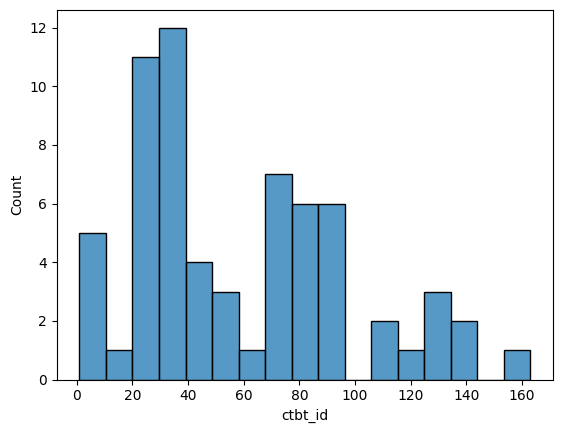

In [143]:
sns.histplot(df_suspicious_votes.groupby('project_address').ctbt_id.count(), bins=17)

We must also look at the ratio of suspicious contributors

In [145]:
df_ctbt_round.groupby('project_address').ctbt_id.count()

project_address
0x01d79bceaeaadfb8fd2f2f53005289cfcf483464     85
0x035a1f3419dd223293e5411133d9c786f5885425    200
0x08a3c2a819e3de7aca384c798269b3ce1cd0e437    162
0x0ea26051f7657d59418da186137141cea90d0652    177
0x0f7272f8873b68b2a2f52685311822d831afc8b4    227
                                             ... 
0xf64bbc221f89cc882fba507908bbe4ae3ad2f470    284
0xfbca78474a09e2bf3543f4fc1037152ea2c6c32d    277
0xfc148c92062ae30d788d48031b89b45237f27af7    144
0xfd9f8a0f4bdeac72f08af1c708023cc31dd2e3be    123
0xfe97e32a873aa2f926fbfc560abeef01f753c128     29
Name: ctbt_id, Length: 66, dtype: int64

In [146]:
df_ctbt_round["suspicious_flag"] = df_ctbt_round['ctbt_address'].apply(lambda x : x in suspicious_address)

In [154]:
df_ctbt_round.groupby(['project_address']).suspicious_flag.sum()

project_address
0x01d79bceaeaadfb8fd2f2f53005289cfcf483464     73
0x035a1f3419dd223293e5411133d9c786f5885425     85
0x08a3c2a819e3de7aca384c798269b3ce1cd0e437    133
0x0ea26051f7657d59418da186137141cea90d0652     57
0x0f7272f8873b68b2a2f52685311822d831afc8b4     93
                                             ... 
0xf64bbc221f89cc882fba507908bbe4ae3ad2f470    107
0xfbca78474a09e2bf3543f4fc1037152ea2c6c32d     78
0xfc148c92062ae30d788d48031b89b45237f27af7     54
0xfd9f8a0f4bdeac72f08af1c708023cc31dd2e3be     35
0xfe97e32a873aa2f926fbfc560abeef01f753c128     25
Name: suspicious_flag, Length: 66, dtype: int64

In [183]:
df_ctbt_round.project_round.unique()

array(['CLIMATE'], dtype=object)

In [158]:
ratio_suspicious_ctbt = df_ctbt_round.groupby(['project_address']).suspicious_flag.sum() / df_ctbt_round.groupby(['project_address']).ctbt_id.count()

In [159]:
ratio_suspicious_ctbt.sort_values(ascending=False)

project_address
0xe126b3e5d052f1f575828f61feba4f4f2603652a    1.000000
0x9cce47e9cf12c6147c9844adbb81fe85880c4df4    1.000000
0x7f06ac71366631157551d97559b82975c293fdba    1.000000
0x7bd7de26ebd064465bb9c272513bb3bcbddb1e93    1.000000
0x799b774204a348e1182fe01074c51444ba70a149    1.000000
                                                ...   
0x81c776d0d7f7d9d3699851993ecaa88a46187f11    0.287234
0xfd9f8a0f4bdeac72f08af1c708023cc31dd2e3be    0.284553
0xfbca78474a09e2bf3543f4fc1037152ea2c6c32d    0.281588
0x14cb60f6aca2b2a68d975743bacb33f01f587da5    0.278226
0x283949d7c2ad3c8bca304df6aa5d9a2a78e02b77    0.000000
Length: 66, dtype: float64

<AxesSubplot: ylabel='Count'>

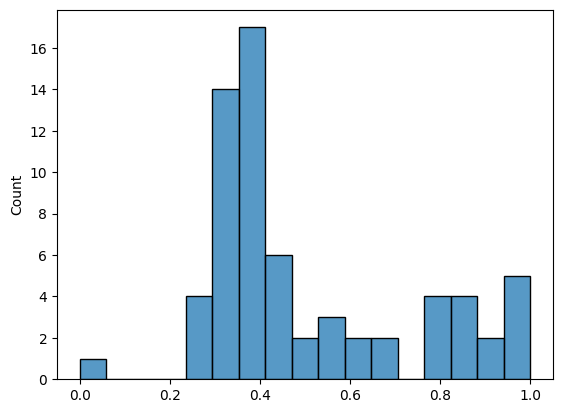

In [160]:
sns.histplot(ratio_suspicious_ctbt, bins=17)

With a ratio of suspicious contributors above 0.7 the project should be investigated.

Histogram with all contributions

<AxesSubplot: xlabel='suspicious_flag', ylabel='Count'>

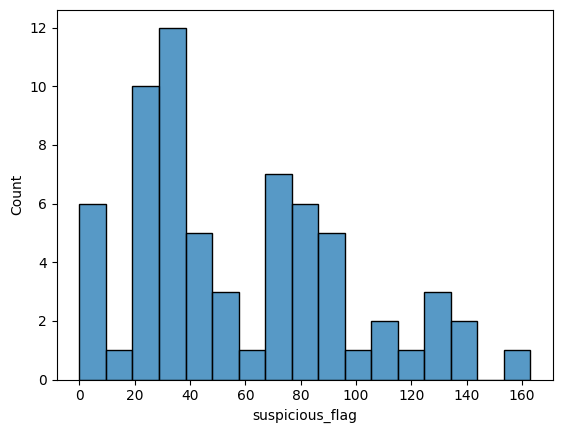

In [155]:
sns.histplot(df_ctbt_round.groupby(['project_address']).suspicious_flag.sum(), bins=17)

Above 60 suspicious flag for a project the project is highly suspicious

## Retrieve suspicious project from climate grant

In [164]:
suspicious_project_address = ratio_suspicious_ctbt[ratio_suspicious_ctbt > 0.7]

In [167]:
print(f"There are {suspicious_project_address.shape[0]} very suspicious projects")

There are 15 very suspicious projects


In [177]:
suspicious_applications = df_applications.loc[df_applications['project_address'].isin(suspicious_project_address.index.values), :]

In [178]:
suspicious_applications

,grant_id,project_active_grant,project_approved,project_address,project_title,project_website,project_decription,project_created_at,project_round,project_long_id,...,project_funding_source,project_team_size,live_on_other_chains,project_value,project_improvements_to_existing,project_github_twitter_credential,project_github_org_link,project_amount_received,project_contributor_count,project_contribution_count
819,0x30b826002362b50fbcc7ee9ccd0515e4ab91c14141d3...,NaN,NaN,0x08a3c2a819e3de7aca384c798269b3ce1cd0e437,DefiLlama,https://defillama.com/,Open and transparent DeFi TVL and analytics. F...,2022-11-18 19:46:02,FANTOM,0x30b826002362b50fbcc7ee9ccd0515e4ab91c14141d3...,...,Previously received funding from Gitcoin Grant...,13,"Yes, DefiLlama tracks almost all chains and Ll...","We track DeFi metrics for fantom projects, suc...",NaN,NaN,NaN,15454.296579,10064.0,11904.0
821,0x37ad3db0b0bc56cea1909e6a6f21fd35453ef27f1d9a...,NaN,NaN,0xe126b3e5d052f1f575828f61feba4f4f2603652a,Revoke.cash - Helping you stay safe in web3,https://revoke.cash,"Hey all, we're building free and open source t...",2022-12-01 22:26:19,FANTOM,0x37ad3db0b0bc56cea1909e6a6f21fd35453ef27f1d9a...,...,Gitcoin Grants,1,"Yes, Revoke.cash supports 30+ chains, and the ...",As a DeFi ecosystem grows more funds will be a...,NaN,NaN,NaN,7404.270070,7842.0,8636.0
985,0x429927c3a14cbe156749adb31371f385749150ac3604...,NaN,NaN,0x7f06ac71366631157551d97559b82975c293fdba,Ethereum on ARM,https://ethereum-on-arm-documentation.readthed...,Help us to build a <$400 PnP Ethereum full/arc...,2023-01-11 13:26:23,ETHEREUM,0x429927c3a14cbe156749adb31371f385749150ac3604...,...,"Gitcoin Grants, EF and QF rounds",2,NaN,NaN,NaN,Yes,NaN,751.312258,411.0,420.0
986,0x46de99c3a4e0542fde6d77bfa1ff6d19e107f253ea52...,NaN,NaN,0x08a3c2a819e3de7aca384c798269b3ce1cd0e437,Chainlist,https://chainlist.org/,"We track all RPCs available for all chains, mo...",2023-01-15 23:49:35,ETHEREUM,0x46de99c3a4e0542fde6d77bfa1ff6d19e107f253ea52...,...,Donations + self-funding,2,NaN,NaN,NaN,Yes,NaN,15454.296579,10064.0,11904.0
996,0x99b81016d61f8b9115282b1055649d4876f386197590...,NaN,NaN,0x9cce47e9cf12c6147c9844adbb81fe85880c4df4,NiceNode: Run a node — just press start,https://nicenode.xyz,\nThe current options to run a node require te...,2023-01-10 20:25:23,ETHEREUM,0x99b81016d61f8b9115282b1055649d4876f386197590...,...,"Gitcoin, CityDAO, EF ESP program",3,NaN,NaN,NaN,"yes for Twitter, working on Github (was an error)",NaN,627.757908,433.0,436.0
1006,0xfce9d62f9a833d6f7185f0051701d5a9e64c83d1daca...,NaN,NaN,0x08a3c2a819e3de7aca384c798269b3ce1cd0e437,DefiLlama APIs,https://defillama.com,DefiLlama provides multiple APIs for free that...,2023-01-14 22:00:59,ETHEREUM,0xfce9d62f9a833d6f7185f0051701d5a9e64c83d1daca...,...,Donations + self-funding,11 full time people + 2 interns,NaN,NaN,NaN,Yes,NaN,15454.296579,10064.0,11904.0
1011,0x0f1d31d427400106f3d2958225dd235ae60b6a7572fb...,NaN,NaN,0x01d79bceaeaadfb8fd2f2f53005289cfcf483464,Lenstube,https://lenstube.xyz,Decentralized video-sharing social media platf...,2023-01-12 06:50:23,OSS,0x0f1d31d427400106f3d2958225dd235ae60b6a7572fb...,...,Nil,1,NaN,NaN,NaN,Yes,"User Account - sasicodes, Organization Account...",3560.551441,3035.0,3121.0
1021,0x20632d089357836c07c38ae6a8b50449fa86c9eef6fd...,NaN,NaN,0x7bd7de26ebd064465bb9c272513bb3bcbddb1e93,White Hat DAO,https://whitehatdao.com,Safety and security should be at the heart of ...,2023-01-08 21:15:59,OSS,0x20632d089357836c07c38ae6a8b50449fa86c9eef6fd...,...,Grants + raising funds through smart contract ...,19,NaN,NaN,NaN,Yes,https://github.com/WhiteHatDAO,164.848446,157.0,160.0
1029,0x3e4b3f7089aa5cb6614b67e235624d01364febe41841...,NaN,NaN,0x1208a26faa0f4ac65b42098419eb4daa5e580ac6,Optinames | ENS on Optimism,https://optinames.eth.limo,What are Optinames?\n\nOptinames are tradable ...,2023-01-15 10:04:47,OSS,0x3e4b3f7089aa5cb6614b67e235624d01364febe41841...,...,Gitcoin Grants,2,NaN,NaN,NaN,Yes,https://github.com/stevegachau,1918.84855

Some projects appears several times because they may have contributed to several grants. and are recorded with the same project_address, yet they where registered with different project_id.

In [179]:
suspicious_applications.project_round.unique()

array(['FANTOM', 'ETHEREUM', 'OSS'], dtype=object)

I think there is a bug somwhere because the project_address should be from the climate round.

# Conclusion
This notebook shows that applying some on chain analysis we can flag addresses and then cross the results with the application data to find projects with a very high ratio of suspicious contributors.